# Load dataset from kaggle

In [8]:
import os
os.environ['KAGGLE_USERNAME'] = "nadaazabmohamed" # from kaggle.json
os.environ['KAGGLE_KEY'] =  "bd4fb6609e0f745b732db37c5c173a65" # from kaggle.json

In [9]:
!kaggle competitions download -c support-23-tom-and-jerry-image-classification

 98% 121M/124M [00:05<00:00, 31.9MB/s]
100% 124M/124M [00:05<00:00, 23.1MB/s]


In [10]:
!unzip /content/support-23-tom-and-jerry-image-classification.zip

Archive:  /content/support-23-tom-and-jerry-image-classification.zip
  inflating: sample_submission.csv   
  inflating: test/test/images/frame100.jpg  
  inflating: test/test/images/frame1006.jpg  
  inflating: test/test/images/frame1011.jpg  
  inflating: test/test/images/frame1012.jpg  
  inflating: test/test/images/frame1013.jpg  
  inflating: test/test/images/frame1049.jpg  
  inflating: test/test/images/frame1059.jpg  
  inflating: test/test/images/frame1065.jpg  
  inflating: test/test/images/frame1074.jpg  
  inflating: test/test/images/frame1080.jpg  
  inflating: test/test/images/frame1082.jpg  
  inflating: test/test/images/frame109.jpg  
  inflating: test/test/images/frame1094.jpg  
  inflating: test/test/images/frame1100.jpg  
  inflating: test/test/images/frame1102.jpg  
  inflating: test/test/images/frame1112.jpg  
  inflating: test/test/images/frame1115.jpg  
  inflating: test/test/images/frame1124.jpg  
  inflating: test/test/images/frame113.jpg  
  inflating: test/test

### Import Libararies

In [11]:
#from google.colab import drive
import csv
import os
import pandas as pd
import numpy as np
import seaborn as sns
from skimage.feature import hog
from skimage.transform import resize
from skimage.io import imread
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss,accuracy_score
import matplotlib.pyplot as plt
import shutil
from tqdm import tqdm

Mount drive folder to workspace

In [12]:
#drive.mount('/content/drive')

# Data loading

In [13]:
# Returns two lists, images, which contains paths to images in the dataset, 
# and labels, containing labels for each image
def load_data(data_dir, csv_file):
    images = []
    labels = []
    # Read the ground truth file
    with open(csv_file, 'r') as f:
        reader = csv.reader(f)
        next(reader) # skip the header
        for row in reader:
            image_file, label =row
            if label in ['neither', 'both']: # only keep images with 1 character
              continue
            image_path = os.path.join(data_dir, image_file)
            images.append(image_path)
            labels.append(label)

    return images, labels

In [18]:
data_dir = 'train/train/images'
csv_file = 'train/train/labels.csv'

In [19]:
images_train, labels = load_data(data_dir, csv_file)

In [20]:
images_train[0], labels[0]

('train/train/images/frame1321.jpg', 'jerry')

In [21]:
len(images_train)

1003

# Histogram Of Gradients (HOG)


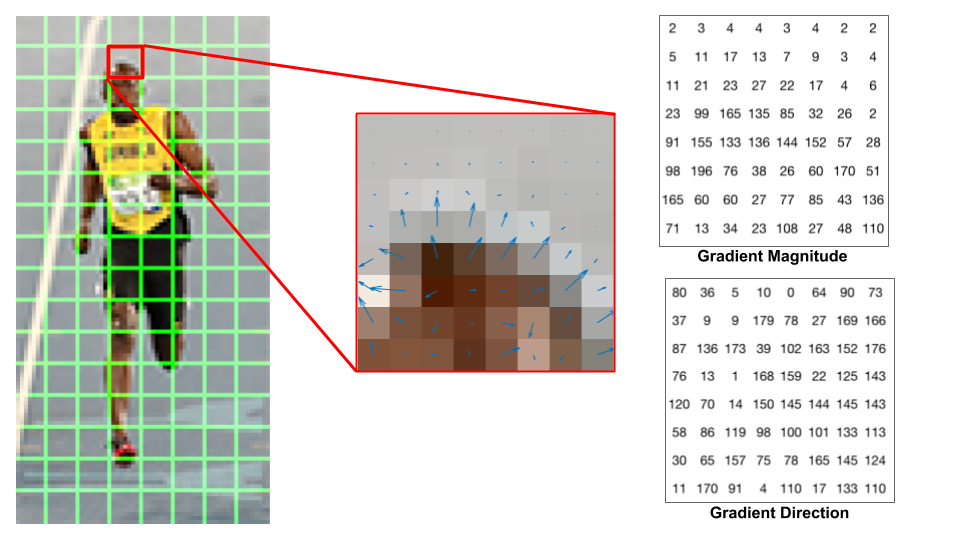

**HOG** is used to convert images into a numerical representaion (vector or "embedding") that can be used in the learning process, as images by themselves do not possess any "features", the details of how HOG works is currently out of our scope.

IMAGE IN ----(HOG)----> "FEATURES" OUT

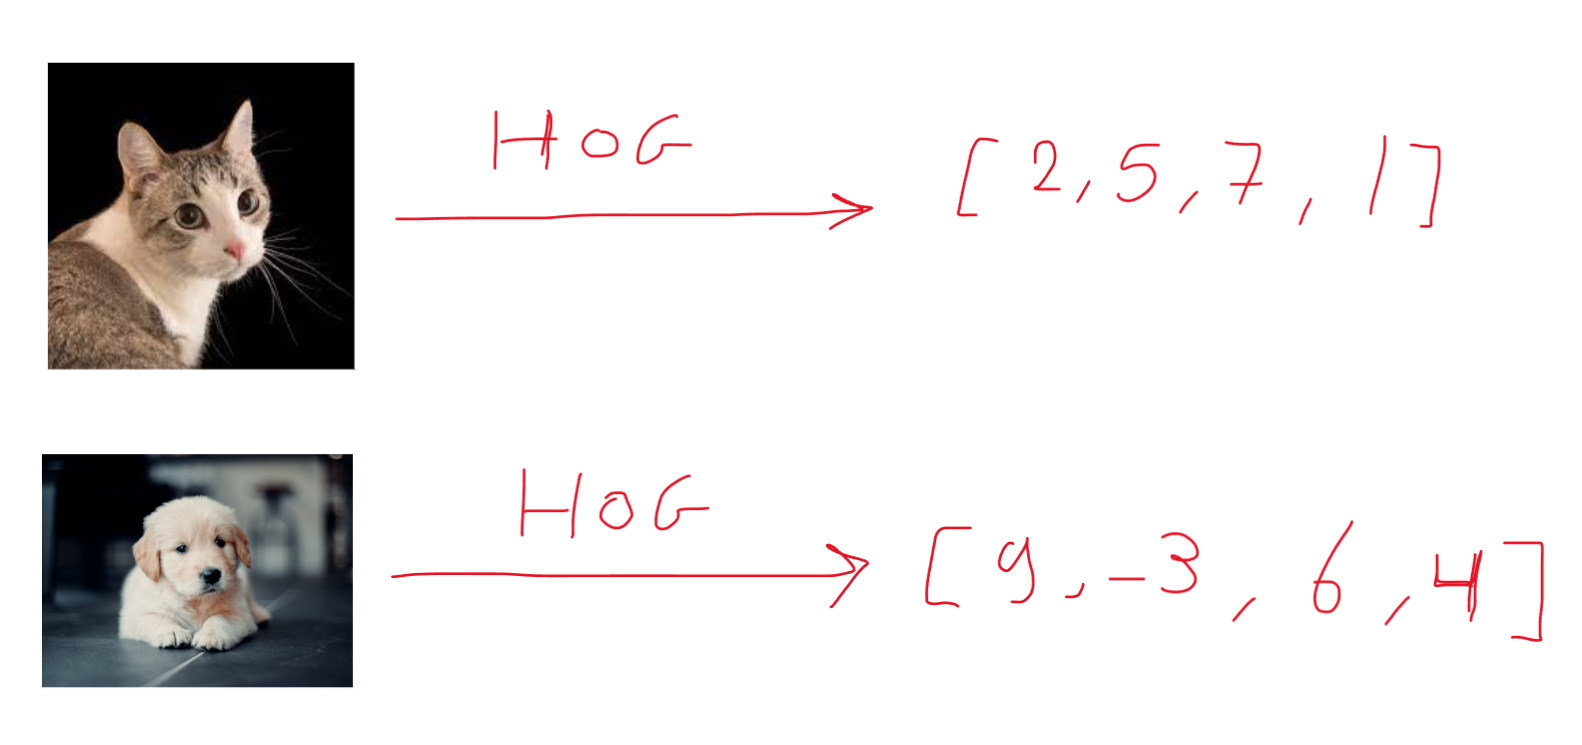

<h2>Visualize the extracted hog features</h2>

Use the following function to see how the images look after extracting the features from them

You can notice how the edges and corner are usually the features that the hog extract as they are very crucial for the algorithm to be able to classify the images
<br><br>

Also try different values of the `pixels_per_cell` argument which controls how many pixels are grouped in each cell block (the green boxes in _Usain Bolt's_ image above)
Smaller Values result in more detailed images but also more features thus more computations

In [22]:
def visualize_hog_features(image_path):
  image = imread(image_path)
  resized_image = resize(image, (128,128))

  fd, observation = hog(resized_image, orientations=5, pixels_per_cell=(2,2),
                          cells_per_block=(2, 2), visualize=True, channel_axis=2)
  
  
  plt.figure(figsize=(13,13))

  ax = plt.subplot(1, 2, 1)
  plt.imshow(resized_image, cmap='gray')
  plt.title("Original Image")
  plt.axis("off")

  ax = plt.subplot(1, 2, 2)
  plt.imshow(observation, cmap='gray')
  plt.title("Hog Image")
  plt.axis("off")

  plt.show()


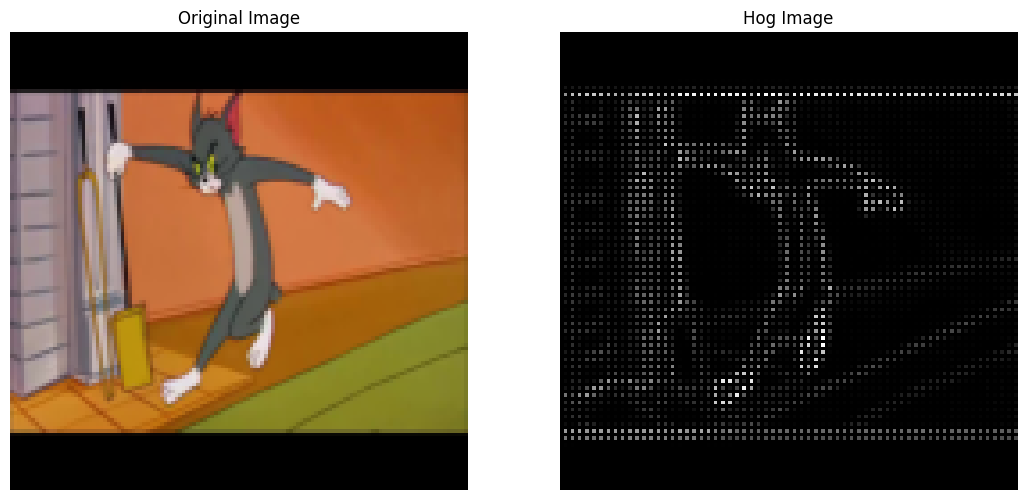

In [23]:
# Change the '4' to view different images and their corresponding Hog Features
visualize_hog_features(images_train[5])

In [24]:
IMG_SIZE = (32, 32)

In [25]:
from joblib import Parallel, delayed

def extract_image_features(image_path):
    image = imread(image_path)
    # Resize the image to the target
    resized_image = resize(image, IMG_SIZE)

    # get hog representation of image
    observation = hog(resized_image, orientations=5, pixels_per_cell=(4,4),
                      cells_per_block=(2, 2), visualize=False, channel_axis=2)
    
    return observation

def extract_dataset_from_images(images):

    # Since we do the same process on all the images we can parellize to save time
    dataset = Parallel(n_jobs=8)(delayed(extract_image_features)(image_path) for image_path in tqdm(images))
    
    return dataset


In [27]:
# path test folder
data_dir_test='test/test/images'
data_dir_test

'test/test/images'

In [28]:
# Exract dataset from test folder
import os
from os import listdir
images_test=[]
# get the path/directory
for images in os.listdir(data_dir_test):
	# check if the image ends with png
	if (images.endswith(".jpg")):images_test.append(os.path.join(data_dir_test,images))
X_test_file = np.array(extract_dataset_from_images(images_test))

100%|██████████| 600/600 [01:52<00:00,  5.31it/s]


In [29]:
# dataset Test 
images_test_file=[]
for images in os.listdir(data_dir_test):
  images_test_file.append(images)
X_TEST=pd.DataFrame(X_test_file)
X_TEST.head()

,0,1,2,3,4,5,6,7,8,9,...,970,971,972,973,974,975,976,977,978,979
0,0.000000,0.0,0.434307,0.0,0.000000,0.000000,0.000000,0.434307,0.000000,0.000000,...,0.000000,0.000000,0.499473,0.000000,0.000000,0.000000,0.0,0.499473,0.0,0.000000
1,0.000000,0.0,0.444179,0.0,0.000000,0.000000,0.000000,0.444179,0.000000,0.000000,...,0.000000,0.000000,0.472604,0.000000,0.000000,0.000000,0.0,0.472604,0.0,0.000000
2,0.404016,0.0,0.000000,0.0,0.441512,0.227897,0.000000,0.024005,0.008577,0.441512,...,0.462006,0.019022,0.066273,0.014295,0.000000,0.462006,0.0,0.000000,0.0,0.000000
3,0.472294,0.0,0.000091,0.0,0.000000,0.472294,0.199729,0.000000,0.036029,0.176428,...,0.371651,0.000000,0.000000,0.000000,0.371651,0.371651,0.0,0.000000,0.0,0.371651
4,0.000000,0.0,0.484110,0.0,0.000000,0.000000,0.000000,0.484110,0.000000,0.000000,...,0.000000,0.000000,0.494822,0.000000,0.000000,0.000000,0.0,0.494822,0.0,0.000000


In [30]:
# This will take a while to finsh, make youself a cup of tea!  #Extract dataset from train folder
X = np.array(extract_dataset_from_images(images_train))
y = np.array(labels)

100%|██████████| 1003/1003 [02:48<00:00,  5.94it/s]


In [31]:
X[0], y[0]

(array([0.34545666, 0.        , 0.        , 0.        , 0.34545666,
        0.34545666, 0.20050214, 0.        , 0.08117657, 0.34545666,
        0.33692418, 0.        , 0.        , 0.        , 0.34545666,
        0.34545666, 0.0253198 , 0.        , 0.06056506, 0.34545666,
        0.38748835, 0.25305922, 0.        , 0.10245516, 0.38748835,
        0.31958519, 0.38748835, 0.19107996, 0.00572668, 0.0101108 ,
        0.38748835, 0.03195681, 0.        , 0.07644082, 0.38748835,
        0.16084771, 0.00627571, 0.01542525, 0.01055459, 0.05311732,
        0.36169171, 0.36169171, 0.32551864, 0.00975582, 0.01722449,
        0.36169171, 0.36169171, 0.28998258, 0.0435692 , 0.20866482,
        0.2740158 , 0.01069113, 0.02627803, 0.01798051, 0.09048922,
        0.15296085, 0.19080148, 0.17596111, 0.21812338, 0.13449749,
        0.34137791, 0.32983591, 0.23629557, 0.03550285, 0.17003287,
        0.1506006 , 0.20688868, 0.34137791, 0.34137791, 0.29038319,
        0.12464187, 0.15547673, 0.14338389, 0.17

# Create dataframe

In [32]:
dataset = pd.DataFrame(X)
dataset["label"] = y

In [33]:
dataset.head()

,0,1,2,3,4,5,6,7,8,9,...,971,972,973,974,975,976,977,978,979,label
0,0.345457,0.000000,0.000000,0.000000,0.345457,0.345457,0.200502,0.000000,0.081177,0.345457,...,0.151195,0.144577,0.000000,0.000000,0.393581,0.0,0.000000,0.000000,0.000000,jerry
1,0.000000,0.000000,0.499044,0.000000,0.000000,0.000000,0.000000,0.499044,0.000000,0.000000,...,0.000000,0.495956,0.000000,0.000000,0.000000,0.0,0.495956,0.000000,0.000000,jerry
2,0.378760,0.044817,0.126460,0.040561,0.282644,0.311831,0.363094,0.296032,0.000000,0.059532,...,0.000000,0.000000,0.258687,0.341210,0.148210,0.0,0.197427,0.341210,0.136141,jerry
3,0.328992,0.000000,0.000000,0.000000,0.365928,0.299412,0.000000,0.066654,0.186278,0.365928,...,0.000000,0.285541,0.330528,0.330528,0.316192,0.0,0.001378,0.001531,0.330528,tom
4,0.000000,0.000000,0.498427,0.000000,0.000000,0.000000,0.000000,0.498427,0.000000,0.000000,...,0.000000,0.424052,0.000000,0.000000,0.000000,0.0,0.424052,0.000000,0.000000,jerry


# Save transformed dataset

Save each image's HOG representation and label into a csv file, you should save this csv file to your drive (google drive) and use later when you return to work (using `pd.read_csv('data.csv')`).

In [34]:
#dataset.to_csv('data.csv')
#shutil.move('data.csv', 'drive/MyDrive/')
#dataset=pd.read_csv('https://drive.google.com/file/d/1v1oxWXahkaV4cp9BEmuDWXjE1-rURoz-/view?usp=share_link')

-------------------------------------------------------------------------------

In [35]:
dataset.isna().sum().sum()

0

# Implement Logistic Regression!


In [36]:
# Data label
# Assigning numerical values and storing in another column
dataset['label']=dataset['label'].replace('tom',0)
dataset['label']=dataset['label'].replace('jerry',1)

In [37]:
# X is the variable holding your samples
# y is the variable holding your labels
X=dataset.drop('label',axis=1).iloc[:,:].values
y=dataset['label']

# scalar=StandardScaler()
# X=scalar.fit_transform(X)
# Have fun!
y

0       1
1       1
2       1
3       0
4       1
       ..
998     0
999     1
1000    1
1001    0
1002    0
Name: label, Length: 1003, dtype: int64

In [38]:
# Feature Selection

from sklearn.feature_selection import chi2,SelectKBest
#define feature selection
fs = SelectKBest(score_func=chi2, k=200)
# apply feature selection
X= fs.fit_transform(X, y)

fs.get_support(indices=True)

array([  2,   6,   7,   8,   9,  12,  17,  21,  22,  23,  24,  25,  26,
        27,  32,  37,  40,  41,  42,  45,  47,  48,  49,  52,  60,  62,
        63,  64,  65,  66,  69,  73,  80,  81,  84,  87,  90,  98, 102,
       105, 107, 112, 113, 117, 118, 120, 122, 125, 127, 132, 136, 137,
       142, 147, 156, 162, 167, 171, 175, 182, 199, 214, 215, 220, 230,
       243, 247, 257, 262, 266, 267, 272, 273, 286, 292, 293, 296, 301,
       305, 311, 329, 336, 344, 345, 349, 360, 387, 402, 403, 416, 417,
       418, 422, 423, 426, 432, 433, 441, 443, 456, 466, 476, 481, 485,
       491, 515, 530, 537, 547, 558, 563, 572, 573, 578, 593, 621, 655,
       656, 667, 670, 671, 697, 698, 708, 711, 712, 723, 735, 739, 750,
       753, 755, 764, 770, 778, 779, 785, 787, 791, 793, 794, 799, 800,
       801, 813, 814, 828, 836, 837, 842, 852, 855, 857, 859, 865, 868,
       870, 872, 877, 880, 883, 890, 892, 894, 906, 908, 909, 910, 913,
       915, 916, 918, 921, 923, 924, 929, 933, 934, 935, 936, 93

In [39]:
# store the best features in list
cols=[]
for i in fs.get_support(indices=True):
    cols.append(dataset.iloc[:,i].name)
print(cols)

[2, 6, 7, 8, 9, 12, 17, 21, 22, 23, 24, 25, 26, 27, 32, 37, 40, 41, 42, 45, 47, 48, 49, 52, 60, 62, 63, 64, 65, 66, 69, 73, 80, 81, 84, 87, 90, 98, 102, 105, 107, 112, 113, 117, 118, 120, 122, 125, 127, 132, 136, 137, 142, 147, 156, 162, 167, 171, 175, 182, 199, 214, 215, 220, 230, 243, 247, 257, 262, 266, 267, 272, 273, 286, 292, 293, 296, 301, 305, 311, 329, 336, 344, 345, 349, 360, 387, 402, 403, 416, 417, 418, 422, 423, 426, 432, 433, 441, 443, 456, 466, 476, 481, 485, 491, 515, 530, 537, 547, 558, 563, 572, 573, 578, 593, 621, 655, 656, 667, 670, 671, 697, 698, 708, 711, 712, 723, 735, 739, 750, 753, 755, 764, 770, 778, 779, 785, 787, 791, 793, 794, 799, 800, 801, 813, 814, 828, 836, 837, 842, 852, 855, 857, 859, 865, 868, 870, 872, 877, 880, 883, 890, 892, 894, 906, 908, 909, 910, 913, 915, 916, 918, 921, 923, 924, 929, 933, 934, 935, 936, 938, 943, 944, 951, 953, 955, 956, 957, 958, 959, 966, 967, 970, 971, 972, 973, 974, 977, 978, 979]


In [40]:
#split dataset to train and test
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=.2,random_state=2)

In [41]:
def init_weights(X: np.ndarray):
  """
  Initial wieghts and bais
    Returns:
    w (ndarray):  a numpy array containing 1 weight for each feature in the data
    b (scalar) : a single number for the bias
  """
  w=np.random.randn(X)
  b=np.random.randn(1)
  return w,b

In [42]:
# Run the above function here
init_weights(X.shape[1])

(array([ 0.53034609,  1.33616755,  0.19622504,  0.1421793 , -1.01147705,
         1.95984324,  0.68328189,  0.53728924,  0.44554631, -1.8123958 ,
        -0.37496768,  0.62902806,  0.13498711, -1.45750744,  0.08408713,
         0.24244164, -0.35438716,  0.04047473, -0.96999049,  0.53269118,
         0.8349181 ,  0.04447776,  0.03212001,  1.63434407, -0.14886264,
         0.67803031,  0.5856023 , -1.13792586,  0.99869295,  0.03898385,
        -0.19215325,  0.34370624, -1.42457713,  1.5924081 ,  1.60835704,
         1.08665471,  0.10152516, -0.88985587,  0.65165524, -0.608319  ,
         0.7963267 ,  1.66750291, -0.96481958,  1.0963931 , -0.20079171,
         0.33908887, -0.85642575, -0.81990305,  0.58552447,  1.38789724,
         0.49192114,  1.05385407, -0.84679012, -0.17759941,  0.55421027,
        -1.26332463, -1.39560556, -0.7830271 ,  1.53556449,  1.95072891,
        -2.25713955, -1.12071115, -1.04072657, -0.47164668,  0.27642414,
         1.24253957,  0.6721778 ,  0.20249117,  1.4

In [43]:
# sigmoid function
def sigmoid (x):
    return 1/(1+(np.exp(-x)))

In [44]:
def predict(X_train, w, b):
  """
    prediction fun
    Args:
      x (ndarray): Shape (n,) example with multiple features
      w (ndarray): Shape (n,) model parameters   
      b (scalar):             model parameter 
      
    Returns:
      prediction (scalar)
    """
  
  prediction=sigmoid(np.dot(X_train,w)+b) #pred (1,1000) but it read (1000,1)
  #reshape != transpose
  return prediction

In [45]:
# Run the above function here
w,b=init_weights(X.shape[1])
predict(X_train,w,b).shape

(802,)

In [46]:
def compute_cost(predictions, y, m):
  """
    Computes error for all the dataset with log loss 
    Args:
      predictions (ndarray (m,)): predicted values of all data
      y (ndarray (m,)) : target values of all data
      m (scalar) : the count of data examples
      
    Returns:
      cost (scalar): cost
    """
  cost=-(1/(m))*np.sum((y*np.log(predictions)+(1-y)*(np.log(1-predictions))))
  return cost 

In [47]:
compute_cost(predict(X_train,w,b),y_train,X.shape[0])  # why cost is so big ? becouse , w,b is randam numbers  in first . we can reduces the cost by put bais nearly the min value in labels.                                                  

0.7503148042166726

In [48]:
predict(X_train,w,b).min()

0.0019462746237078562

In [49]:
def update_weights(prediction,x,w,b, alpha,y):
  """
    Args:
      w (ndarray)     : Shape (n,) model parameters

      b (scalar)      : model parameter 
      
      alpha (scalar)  : learning rate

      y (ndarray (m,)) : target values of all data
      
    Returns:
      w (ndarray)     : Shape (n,) Updated weights
      b (scalar)      : Updated bias
  """
  
  for i in range(0,(len(w))):
    w[i]=w[i]-(alpha*(sum((prediction-y)*(x[:,i]))))
    #when use log you should decrese alpha becouse prediections is very near from 1 or zero .
  b=b-(alpha*sum((prediction-y)*1)) 
  return w,b

In [50]:
len(w) 

200

In [51]:
# Run the above function here
alpha=.0003
print("--------",b.shape,w.shape)
W,B=update_weights(predict(X_train,w,b),X_train,w, b,alpha,y_train)
#B=int(B)
print("#####",B.shape,W.shape)
B

-------- (1,) (200,)
##### (1,) (200,)


array([1.43612178])

In [52]:
predict(X_train,w,b).min()

0.0020565305928866963

In [53]:
def fit(x, y, epochs, alpha):
  """
    Fits a linear regression line on the data using gradient descent
    (This function should be where you use all your other functions in)
    Args:
      x (ndarray (m,n))      : Data, m examples with n features
      labels (ndarray (m,))  : target values
      epochs (scalar)        : number of iterations done on all data
      alpha (scalar)         : learning rate
    Returns:
      learned parameters and cost_history
  """
  cost_history = [] # add cost after each epoch to this list and return it with the parameters
  w,b=init_weights(x.shape[1])
  for i in range(1,epochs+1):
    predicted=predict(X_train,w,b)
    cost=compute_cost(predict(X_train,w,b),y_train,X.shape[0])
    print("Cost for epoch{} : {}".format(i,cost))
    cost_history.append(cost)
    w,b=update_weights(predict(X_train,w,b),X_train,w, b,alpha,y_train)
    # y_pred=predict(X_test,w,b)
    # accurecy=accuracy_score(y_test,y_pred)
    # print(accurecy)
  return w,b,cost_history

In [55]:
epochs =1000 # <- add epochs count  
alpha  =.003# <- add learning rate between ]0,1]
learned_weights,learned_bias, cost_history = fit(X_train,y_train, epochs, alpha)

Cost for epoch1 : 0.8371648727677148
Cost for epoch2 : 0.6983452842703467
Cost for epoch3 : 0.6552571355975843
Cost for epoch4 : 0.6301786945801088
Cost for epoch5 : 0.6177685643757074
Cost for epoch6 : 0.6052629684448154
Cost for epoch7 : 0.5982223398908176
Cost for epoch8 : 0.5885364433138326
Cost for epoch9 : 0.5843158104558033
Cost for epoch10 : 0.5760396580035961
Cost for epoch11 : 0.5747825009178046
Cost for epoch12 : 0.567249484812868
Cost for epoch13 : 0.5694632638784877
Cost for epoch14 : 0.5618018177067777
Cost for epoch15 : 0.5679713984890439
Cost for epoch16 : 0.5589157797172396
Cost for epoch17 : 0.5692017935693429
Cost for epoch18 : 0.5572845823643359
Cost for epoch19 : 0.5712995946808637
Cost for epoch20 : 0.5554350684226577
Cost for epoch21 : 0.5722898262662182
Cost for epoch22 : 0.5523439331618288
Cost for epoch23 : 0.570956412606808
Cost for epoch24 : 0.54775466458318
Cost for epoch25 : 0.5671727346611853
Cost for epoch26 : 0.5419805919527955
Cost for epoch27 : 0.5615

In [56]:
# predict the test images
y_pred=predict(X_test,learned_weights,learned_bias)
#print(y_pred)
for num,val in enumerate( y_pred):
  if val>.5 :
    y_pred[num]=1
  else :
    y_pred[num]=0  
#print(y_pred,"----------y_test",np.array( y_test))
accurecy=accuracy_score(y_test,y_pred)
accurecy

0.7412935323383084

In [57]:
model_parameters_best=epochs,learned_bias,learned_weights
model_parameters_best[2]

array([-0.50228065,  1.76213357,  2.36767874,  1.22325663,  0.90762718,
       -0.59745971,  1.74121781, -0.00584351, -4.39715327,  0.20637145,
       -0.4190273 , -0.83989858,  0.04349265, -1.28580605, -0.79877849,
       -2.55827882,  0.73373745, -0.05342113,  0.76128488,  2.38463455,
        0.56149043,  1.86894581,  1.56048623,  0.39428735, -0.91766234,
       -1.40356192,  1.08407227,  0.33260746, -0.67011507, -0.92897974,
        1.49993678, -0.79402899, -0.06529502,  0.14862406, -0.9513538 ,
       -1.16641557, -1.81656369, -1.57429011,  1.18174817,  0.92095359,
        0.28967151,  1.44546176,  0.76781855,  0.39923593, -0.23066284,
        2.28290231,  1.31819258, -0.41507876,  0.52319017, -0.7567536 ,
       -1.07956509, -1.05285694,  1.54774509,  0.29916572,  1.48197852,
       -0.83811382, -0.78763066,  0.77930973, -0.88033198, -0.95805966,
       -0.91787136,  0.68547871, -0.72468763,  0.06009393,  0.34306251,
       -0.36867339,  0.42615508, -0.06501672,  0.55493883, -1.66

In [58]:
#save prameter model
with open('best_pram_model.txt','w') as f:
        f.write("epochs:\n")
        f.write('%f' % model_parameters_best[0]+'\n')
        f.write("bais:\n")
        f.write('%f' % model_parameters_best[1]+'\n')
        f.write("learned_wieghts:\n")# starting index -->5
        np.savetxt('best_pram_model.txt', model_parameters_best[2])

In [59]:
learned_wieghts=[]
with open('best_pram_model.txt') as f:
    pram = f.readlines()
    for i in range(0,(len(pram)-2)):
        learned_wieghts.append(pram[i])
    print(learned_wieghts)

['epochs:\n', '1000.000000\n', 'bais:\n', '0.523347\n', 'learned_wieghts:\n', '.367678738008653472e+00\n', '1.223256630665313427e+00\n', '9.076271829780055977e-01\n', '-5.974597113606456844e-01\n', '1.741217806355468634e+00\n', '-5.843508954527603522e-03\n', '-4.397153273866488021e+00\n', '2.063714471662889405e-01\n', '-4.190272981748421333e-01\n', '-8.398985758972929982e-01\n', '4.349265159439186929e-02\n', '-1.285806050511637766e+00\n', '-7.987784932334731636e-01\n', '-2.558278817383457415e+00\n', '7.337374546422239519e-01\n', '-5.342112625686153138e-02\n', '7.612848755350528629e-01\n', '2.384634547049433895e+00\n', '5.614904287862052534e-01\n', '1.868945813076527740e+00\n', '1.560486231531080126e+00\n', '3.942873507627058238e-01\n', '-9.176623361156451830e-01\n', '-1.403561918675482190e+00\n', '1.084072268042963527e+00\n', '3.326074573958044400e-01\n', '-6.701150741658785659e-01\n', '-9.289797419845842175e-01\n', '1.499936778155458894e+00\n', '-7.940289896347028087e-01\n', '-6.52950

# Make predictions for the test data
(you'll need to reuse some code from above to prepare the test set)

In [60]:
# predict Test images for competition
X_TEST=X_TEST[cols]
y_pred_TSET=predict(X_TEST,learned_weights,learned_bias)
#print(y_pred_TSET)
for num,val in enumerate(y_pred_TSET):
  if val>.5 :
    y_pred_TSET[num]=1
  else :
    y_pred_TSET[num]=0  
#print(y_pred_TSET.shape)    

## Create model with sklearn

In [61]:
# feature selection
from sklearn.feature_selection import chi2,SelectKBest
#define feature selection
fs = SelectKBest(score_func=chi2, k=200)
# apply feature selection
X_train= fs.fit_transform(X_train,y_train)

fs.get_support(indices=True)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [62]:
cols=[]
for i in fs.get_support(indices=True):
    cols.append(dataset.iloc[:,i].name)
print(cols)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199]


In [63]:
from sklearn.linear_model import LogisticRegression
logistic=LogisticRegression().fit(X_train,y_train)

In [64]:
y_pred_model=logistic.predict(X_test)

In [65]:
accurecy_sk=accuracy_score(y_test,y_pred_model)
accurecy_sk

0.7014925373134329

# Add your predictions to the submission file and save it

In [66]:
submission_images=pd.DataFrame(data=images_test_file , columns =['image'])

submission_label=pd.DataFrame(data=y_pred_TSET).astype('int')
submission_images.insert(1, column = "label", value =submission_label)  
submission_images.to_csv('submission.csv', index=False)

In [67]:
submission_images.head()

,image,label
0,frame3024.jpg,0
1,frame1262.jpg,0
2,frame4830.jpg,0
3,frame3905.jpg,0
4,frame3473.jpg,0
